In [1]:
#object_lid = 5
#object_lid = 6
#object_lid = 8
object_lid = 9
#object_lid = 11
#object_lid = 12

In [2]:
import sys
sys.path.append('/code/foundpose')
sys.path.append('/code/foundpose/external/bop_toolkit')
sys.path.append('/code/foundpose/external/dinov2')

In [3]:
import bop_toolkit_lib.config as bop_config
import bop_toolkit_lib.misc as bop_misc
import cv2
import datetime
import gc
import numpy as np
import os
import time
import torch

from bop_toolkit_lib import inout, dataset_params
from typing import List, NamedTuple, Optional, Tuple
from utils import (
    corresp_util,
    config_util,
    eval_errors,
    eval_util,
    feature_util,
    infer_pose_util,
    knn_util,
    misc as misc_util,
    pnp_util,
    projector_util,
    repre_util,
    vis_util,
    data_util,
    renderer_builder,
    json_util, 
    logging,
    misc,
    structs,
)
from utils.misc import array_to_tensor, tensor_to_array, tensors_to_arrays
from utils.misc import warp_depth_image, warp_image
from utils.structs import AlignedBox2f, PinholePlaneCameraModel

In [4]:
logger: logging.Logger = logging.get_logger()

In [5]:
class InferOpts(NamedTuple):
    """Options that can be specified via the command line."""

    version: str
    repre_version: str
    object_dataset: str
    object_lids: Optional[List[int]] = None
    max_sym_disc_step: float = 0.01

    # Cropping options.
    crop: bool = True
    crop_rel_pad: float = 0.2
    crop_size: Tuple[int, int] = (420, 420)

    # Object instance options.
    use_detections: bool = True
    num_preds_factor: float = 1.0
    min_visibility: float = 0.1

    # Feature extraction options.
    extractor_name: str = "dinov2_vitl14"
    grid_cell_size: float = 1.0
    max_num_queries: int = 1000000

    # Feature matching options.
    match_template_type: str = "tfidf"
    match_top_n_templates: int = 5
    match_feat_matching_type: str = "cyclic_buddies"
    match_top_k_buddies: int = 300

    # PnP options.
    pnp_type: str = "opencv"
    pnp_ransac_iter: int = 1000
    pnp_required_ransac_conf: float = 0.99
    pnp_inlier_thresh: float = 10.0
    pnp_refine_lm: bool = True

    final_pose_type: str = "best_coarse"

    # Other options.
    save_estimates: bool = True
    vis_results: bool = True
    vis_corresp_top_n: int = 100
    vis_feat_map: bool = True
    vis_for_paper: bool = True
    debug: bool = True

In [6]:
opts_type = InferOpts
opts_name = 'infer_opts'
opts = config_util.load_opts_from_json(path='/code/foundpose/configs/infer/lmo.json', opts_types={opts_name: opts_type})[opts_name]

In [7]:
datasets_path = "/Datasets/bop"

In [8]:
logger = logging.get_logger(level=logging.INFO if opts.debug else logging.WARNING)
timer = misc_util.Timer(enabled=opts.debug)
timer.start()

In [9]:
# Load pre-generated detections saved in the BOP format.
detections = {}
if opts.use_detections:
    path = os.path.join(
        datasets_path,
        "detections",
        "cnos-fastsam",
        f"cnos-fastsam_{opts.object_dataset}-test.json",
    )
    detections = infer_pose_util.load_detections_in_bop_format(path)

In [10]:
# Prepare feature extractor.
extractor = feature_util.make_feature_extractor(opts.extractor_name)
# Prepare a device.
device = "cuda" if torch.cuda.is_available() else "cpu"
extractor.to(device)

/code/foundpose/external/dinov2/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/code/foundpose/external/dinov2/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/code/foundpose/external/dinov2/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
I0528 11:23:18.965 4329 vision_transformer.py:122] using MLP layer as FFN


DinoFeatureExtractor(
  (model): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
    

In [11]:
# Get IDs of objects to process.
object_lids = opts.object_lids
bop_model_props = dataset_params.get_model_params(datasets_path=datasets_path, dataset_name=opts.object_dataset)
if object_lids is None:
    # If local (object) IDs are not specified, synthesize templates for all objects
    # in the specified dataset.
    object_lids = bop_model_props["obj_ids"]

# Get properties of the test split of the specified dataset.
bop_test_split_props = dataset_params.get_split_params(
    datasets_path=datasets_path,
    dataset_name=opts.object_dataset,
    split="test"
)

In [12]:
# Load BOP test targets
test_targets_path = os.path.join(bop_test_split_props["base_path"], "test_targets_bop19.json")
targets = inout.load_json(test_targets_path)

In [13]:
targets = targets[:8] # select first im_id

In [14]:
scene_ids = dataset_params.get_present_scene_ids(bop_test_split_props)

In [15]:
scene_im_ids = {}
test_target_count = {}
targets_per_obj = {}
for target in targets:
    scene_im_ids.setdefault(target["scene_id"], set()).add(target["im_id"])
    key = (target["scene_id"], target["im_id"], target["obj_id"])
    test_target_count[key] = target["inst_count"]
    targets_per_obj.setdefault(target["obj_id"], list()).append(target)

In [16]:
scene_gts = {}
scene_gts_info = {}
scene_cameras = {}
for scene_id in scene_im_ids.keys():
    scene_cameras[scene_id] = data_util.load_chunk_cameras(bop_test_split_props["scene_camera_tpath"].format(scene_id=scene_id), bop_test_split_props["im_size"])
    scene_gts[scene_id] = data_util.load_chunk_gts(bop_test_split_props["scene_gt_tpath"].format(scene_id=scene_id),opts.object_dataset)
    scene_gts_info[scene_id] = json_util.load_json(
        bop_test_split_props["scene_gt_info_tpath"].format(scene_id=scene_id),
        keys_to_int=True,
    )

In [17]:
# Create a renderer.
renderer_type = renderer_builder.RendererType.PYRENDER_RASTERIZER
renderer = renderer_builder.build(renderer_type=renderer_type, model_path=bop_model_props["model_tpath"])

timer.elapsed("Time for setting up the stage")

I0528 11:23:19.582 4329 acceleratesupport.py:24] No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
I0528 11:23:19.672 4329 misc.py:41] Time for setting up the stage: 0.96348s


0.9634790420532227

In [18]:
timer.start()

In [19]:
# The output folder is named with slugified dataset path.
version = opts.version
if version == "":
    version = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
signature = misc.slugify(opts.object_dataset) + "_{}".format(version)
output_dir = os.path.join(
    "/Workspace/inference", signature, str(object_lid)
)
os.makedirs(output_dir, exist_ok=True)

In [20]:
# Save parameters to a file.
config_path = os.path.join(output_dir, "config.json")
json_util.save_json(config_path, opts)

In [21]:
# Create a pose evaluator.
pose_evaluator = eval_util.EvaluatorPose([object_lid])

In [22]:
# Load the object representation.
logger.info(
    f"Loading representation for object {object_lid} from dataset {opts.object_dataset}..."
)
base_repre_dir = os.path.join("/Workspace/object_repre")
repre_dir = repre_util.get_object_repre_dir_path(
    base_repre_dir, opts.version, opts.object_dataset, object_lid
)
repre = repre_util.load_object_repre(
    repre_dir=repre_dir,
    tensor_device=device,
)

logger.info("Object representation loaded.")
repre_np = repre_util.convert_object_repre_to_numpy(repre)

I0528 11:23:19.689 4329 2171748784.py:2] Loading representation for object 9 from dataset lmo...
I0528 11:23:19.689 4329 repre_util.py:150] Loading repre from: /Workspace/object_repre/lmo/v1/9/repre.pth
/code/foundpose/utils/repre_util.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have fu

In [23]:
# Build a kNN index from object feature vectors.
visual_words_knn_index = None
if opts.match_template_type == "tfidf":
    visual_words_knn_index = knn_util.KNN(
        k=repre.template_desc_opts.tfidf_knn_k,
        metric=repre.template_desc_opts.tfidf_knn_metric
    )
    visual_words_knn_index.fit(repre.feat_cluster_centroids)

/opt/conda/lib/python3.11/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


In [24]:
# Build per-template KNN index with features from that template.
template_knn_indices = []
if opts.match_feat_matching_type == "cyclic_buddies":
    logger.info("Building per-template KNN indices...")
    for template_id in range(len(repre.template_cameras_cam_from_model)):
        #logger.info(f"Building KNN index for template {template_id}...")
        tpl_feat_mask = repre.feat_to_template_ids == template_id
        tpl_feat_ids = torch.nonzero(tpl_feat_mask).flatten()

        template_feats = repre.feat_vectors[tpl_feat_ids]

        # Build knn index for object features.
        template_knn_index = knn_util.KNN(k=1, metric="l2")
        template_knn_index.fit(template_feats.cpu())
        template_knn_indices.append(template_knn_index)
    logger.info("Per-template KNN indices built.")

logging.log_heading(
    logger,
    f"Object: {object_lid}, vertices: {len(repre.vertices)}",
    style=logging.WHITE_BOLD,
)

I0528 11:23:20.249 4329 2340513475.py:4] Building per-template KNN indices...
I0528 11:23:20.397 4329 2340513475.py:16] Per-template KNN indices built.
I0528 11:23:20.398 4329 logging.py:117] --------------------------------------------------------------------------------
I0528 11:23:20.398 4329 logging.py:118] Object: 9, vertices: 140504
I0528 11:23:20.398 4329 logging.py:119] --------------------------------------------------------------------------------


In [25]:
# Get the object mesh and meta information.
model_path = bop_model_props["model_tpath"].format(obj_id=object_lid)
object_mesh = inout.load_ply(model_path)
models_info = inout.load_json(bop_model_props["models_info_path"], keys_to_int=True)
object_syms = bop_misc.get_symmetry_transformations(
    models_info[object_lid], max_sym_disc_step= 0.01
)
object_diameter = models_info[object_lid]["diameter"]

max_vertices = 1000
subsampled_vertices = np.random.permutation(object_mesh["pts"])[:max_vertices]

timer.elapsed("Time for preparing object data")

I0528 11:23:20.445 4329 misc.py:41] Time for preparing object data: 0.76969s


0.7696912288665771

In [26]:
item_info = targets_per_obj[object_lid][0]
timer.start()

In [27]:
item_info

{'im_id': 3, 'inst_count': 1, 'obj_id': 9, 'scene_id': 2}

In [28]:
# Chunk and image IDs in the original BOP dataset.
bop_im_id = item_info["im_id"]
bop_chunk_id = item_info["scene_id"]

In [29]:
# Get instance identifier if specified.
inst_id = None
if "inst_id" in item_info:
    inst_id = item_info["inst_id"]

sample = data_util.prepare_sample(
    item_info,
    bop_test_split_props,
    scene_cameras,
    scene_gts,
    scene_gts_info
)

In [30]:
# Get object annotations.
object_annos = []
if sample.objects_anno is not None:
    all_object_annos = None
    if inst_id is not None:
        all_object_annos = [sample.objects_anno[inst_id]]
    else:
        all_object_annos = sample.objects_anno

    # Keep only GT annotations for sufficiently visible objects.
    for anno in all_object_annos:
        if (
            anno.lid == object_lid
            and not np.isnan(anno.visibilities)
            and anno.visibilities > opts.min_visibility
        ):
            object_annos.append(anno)

    if len(object_annos) == 0:
        logger.info('there are no sufficiently visible object annos')

In [31]:
# If test targets are specified use them to get the number of target instances.
sample_key = (bop_chunk_id, bop_im_id, object_lid)
if test_target_count is not None:
    # For test images.
    if sample_key not in test_target_count:
        logger.info('sample_key not in test_target_count')
    # Number of target instances
    num_target_insts = test_target_count[sample_key]

else:
    num_target_insts = len(object_annos)

In [32]:
msg = (
    f"Estimating pose of object {object_lid} in "
    f"scene_id {bop_chunk_id}, im_id {bop_im_id}"
    f"dataset {datasets_path}"
)
logging.log_heading(logger, msg, style=logging.BLUE_BOLD)

I0528 11:23:20.494 4329 logging.py:117] --------------------------------------------------------------------------------
I0528 11:23:20.495 4329 logging.py:118] Estimating pose of object 9 in scene_id 2, im_id 3dataset /Datasets/bop
I0528 11:23:20.495 4329 logging.py:119] --------------------------------------------------------------------------------


In [33]:
# Camera parameters.
orig_camera_c2w = sample.camera
orig_image_size = (
    orig_camera_c2w.width,
    orig_camera_c2w.height,
)

In [34]:
# Get info about object instances for which we want to estimate pose.
instances = infer_pose_util.get_instances_for_pose_estimation(
    bop_chunk_id=bop_chunk_id,
    bop_im_id=bop_im_id,
    obj_id=object_lid,
    use_detections=opts.use_detections,
    detections=detections,
    max_num_preds=int(opts.num_preds_factor * num_target_insts),
    gt_object_annos=object_annos,
    image_size=orig_image_size,
)
if len(instances) == 0:
    logger.info("No object instance, skipping.")

In [35]:
# Generate grid points at which to sample the feature vectors.
if opts.crop:
    grid_size = opts.crop_size
else:
    grid_size = orig_image_size
grid_points = feature_util.generate_grid_points(
    grid_size=grid_size,
    cell_size=opts.grid_cell_size,
)
grid_points = grid_points.to(device)

timer.elapsed("Time for preparing image data")

I0528 11:23:20.505 4329 misc.py:41] Time for preparing image data: 0.05661s


0.056610822677612305

In [36]:
inst_j=0
instance = instances[0]
times = {}

In [37]:
if opts.use_detections:
    # Add time for CNOS prediction.
    pose_evaluator.detection_times[(bop_chunk_id, bop_im_id)] = (
        instance["time"]
    )
    cnos_time = instance["time"]
    logger.info(f"Time for segmentation: {cnos_time:.5f}s")

    # Skip the prediction mask if it doesn't overlap with the ground truth.
    if instance["gt_anno"] is not None:
        mask_iou = eval_errors.mask_iou(
            instance["input_mask_modal"],
            instance["gt_anno"].masks_modal,
        )
        if mask_iou < 0.05:
            logger.info("the prediction mask doesn't overlap with the ground truth")

    # Skip if the detection covers more than half of the image (e.g. itodd).
    if (
        instance["input_mask_modal"].sum()
        > orig_image_size[0] * orig_image_size[1]
    ):
        logger.info('the detection covers more than half of the image')
else:
    pose_evaluator.detection_times[(bop_chunk_id, bop_im_id)] = 0

I0528 11:23:20.511 4329 1924411633.py:7] Time for segmentation: 0.33597s


In [38]:
# Get the input image.
orig_image_np_hwc = sample.image.astype(np.float32)/255.0

In [39]:
from PIL import Image
import matplotlib.pyplot as plt

In [40]:
%matplotlib inline

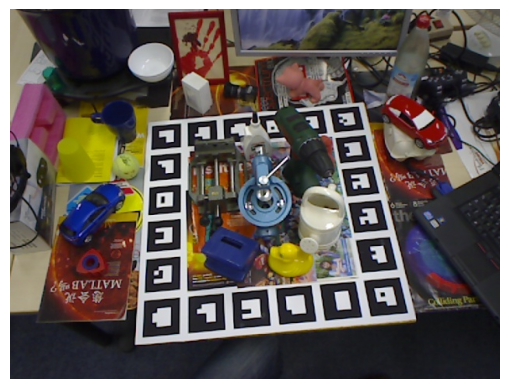

In [41]:
plt.imshow(orig_image_np_hwc)
plt.axis('off')
plt.show()

In [42]:
# Get the modal mask and amodal bounding box of the instance.
orig_mask_modal = instance["input_mask_modal"]
orig_box_amodal = AlignedBox2f(
    left=instance["input_box_amodal"][0],
    top=instance["input_box_amodal"][1],
    right=instance["input_box_amodal"][2],
    bottom=instance["input_box_amodal"][3],
)

In [43]:
timer.start()

In [44]:
# Get box for cropping.
crop_box = misc_util.calc_crop_box(
    box=orig_box_amodal,
    make_square=True,
)

In [45]:
# Construct a virtual camera focused on the crop.
crop_camera_model_c2w = misc_util.construct_crop_camera(
    box=crop_box,
    camera_model_c2w=orig_camera_c2w,
    viewport_size=opts.crop_size,
    viewport_rel_pad=opts.crop_rel_pad,
)

In [46]:
# Map images to the virtual camera.
interpolation = (
    cv2.INTER_AREA
    if crop_box.width >= crop_camera_model_c2w.width
    else cv2.INTER_LINEAR
)
image_np_hwc = warp_image(
    src_camera=orig_camera_c2w,
    dst_camera=crop_camera_model_c2w,
    src_image=orig_image_np_hwc,
    interpolation=interpolation,
)
mask_modal = warp_image(
    src_camera=orig_camera_c2w,
    dst_camera=crop_camera_model_c2w,
    src_image=orig_mask_modal,
    interpolation=cv2.INTER_NEAREST,
)

In [47]:
# Recalculate the object bounding box (it changed if we constructed the virtual camera).
ys, xs = mask_modal.nonzero()
box = np.array(misc_util.calc_2d_box(xs, ys))
box_amodal = AlignedBox2f(
    left=box[0],
    top=box[1],
    right=box[2],
    bottom=box[3],
)

In [48]:
# The virtual camera is becoming the main camera.
camera_c2w = crop_camera_model_c2w

In [49]:
times["prep"] = timer.elapsed("Time for preparation")
timer.start()

I0528 11:23:20.717 4329 misc.py:41] Time for preparation: 0.05499s


In [50]:
# Extract feature map from the crop.
image_tensor_chw = array_to_tensor(image_np_hwc).to(torch.float32).permute(2,0,1).to(device)
image_tensor_bchw = image_tensor_chw.unsqueeze(0)
extractor_output = extractor(image_tensor_bchw)
feature_map_chw = extractor_output["feature_maps"][0]

times["feat_extract"] = timer.elapsed("Time for feature extraction")
timer.start()

I0528 11:23:20.883 4329 misc.py:41] Time for feature extraction: 0.16621s


In [51]:
# Keep only points inside the object mask.
mask_modal_tensor = array_to_tensor(mask_modal).to(device)
query_points = feature_util.filter_points_by_mask(
    grid_points, mask_modal_tensor
)

In [52]:
# Subsample query points if we have too many.
if query_points.shape[0] > opts.max_num_queries:
    perm = torch.randperm(query_points.shape[0])
    query_points = query_points[perm[: opts.max_num_queries]]
    msg = (
        "Randomly sumbsampled queries "
        f"({perm.shape[0]} -> {query_points.shape[0]}))"
    )
    logging.log_heading(logger, msg, style=logging.RED_BOLD)

In [53]:
# Extract features at the selected points, of shape (num_points, feat_dims).
timer.start()
query_features = feature_util.sample_feature_map_at_points(
    feature_map_chw=feature_map_chw,
    points=query_points,
    image_size=(image_np_hwc.shape[1], image_np_hwc.shape[0]),
).contiguous()

times["grid_sample"] = timer.elapsed("Time for grid sample")
timer.start()

I0528 11:23:20.917 4329 misc.py:41] Time for grid sample: 0.00585s


In [54]:
# Potentially project features to a PCA space.
if (
    query_features.shape[1] != repre.feat_vectors.shape[1]
    and len(repre.feat_raw_projectors) != 0
):
    query_features_proj = projector_util.project_features(
        feat_vectors=query_features,
        projectors=repre.feat_raw_projectors,
    ).contiguous()

    _c, _h, _w = feature_map_chw.shape
    feature_map_chw_proj = (
        projector_util.project_features(
            feat_vectors=feature_map_chw.permute(1, 2, 0).view(-1, _c),
            projectors=repre.feat_raw_projectors,
        )
        .view(_h, _w, -1)
        .permute(2, 0, 1)
    )
else:
    query_features_proj = query_features
    feature_map_chw_proj = feature_map_chw

times["proj"] = timer.elapsed("Time for projection")
timer.start()

I0528 11:23:20.924 4329 misc.py:41] Time for projection: 0.00667s


In [55]:
# Establish 2D-3D correspondences.
corresp = []
if len(query_points) != 0:
    corresp = corresp_util.establish_correspondences(
        query_points=query_points,
        query_features=query_features_proj,
        object_repre=repre,
        template_matching_type=opts.match_template_type,
        template_knn_indices=template_knn_indices,
        feat_matching_type=opts.match_feat_matching_type,
        top_n_templates=opts.match_top_n_templates,
        top_k_buddies=opts.match_top_k_buddies,
        visual_words_knn_index=visual_words_knn_index,
        debug=opts.debug,
    )

times["corresp"] = timer.elapsed("Time for corresp")
timer.start()

logger.info(
    f"Number of corresp: {[len(c['coord_2d']) for c in corresp]}"
)

I0528 11:23:21.91 4329 template_util.py:199] Matched templates: [715, 685, 714, 672, 684]
I0528 11:23:21.92 4329 misc.py:41] Time for template matching: 0.15879s
I0528 11:23:21.108 4329 misc.py:41] Time for establishing corresp: 0.01653s
I0528 11:23:21.109 4329 misc.py:41] Time for corresp: 0.18076s
I0528 11:23:21.109 4329 4180358686.py:20] Number of corresp: [178, 178, 178, 178, 178]


In [56]:
# Estimate coarse poses from correspondences.
coarse_poses = []
for corresp_id, corresp_curr in enumerate(corresp):

    # We need at least 3 correspondences for P3P.
    num_corresp = len(corresp_curr["coord_2d"])
    if num_corresp < 6:
        logger.info(f"Only {num_corresp} correspondences, skipping.")
        continue

    (
        coarse_pose_success,
        R_m2c_coarse,
        t_m2c_coarse,
        inliers_coarse,
        quality_coarse,
    ) = pnp_util.estimate_pose(
        corresp=corresp_curr,
        camera_c2w=camera_c2w,
        pnp_type=opts.pnp_type,
        pnp_ransac_iter=opts.pnp_ransac_iter,
        pnp_inlier_thresh=opts.pnp_inlier_thresh,
        pnp_required_ransac_conf=opts.pnp_required_ransac_conf,
        pnp_refine_lm=opts.pnp_refine_lm,
    )

    logger.info(
        f"Quality of coarse pose {corresp_id}: {quality_coarse}"
    )

    if coarse_pose_success:
        coarse_poses.append(
            {
                "type": "coarse",
                "R_m2c": R_m2c_coarse,
                "t_m2c": t_m2c_coarse,
                "corresp_id": corresp_id,
                "quality": quality_coarse,
                "inliers": inliers_coarse,
            }
        )

I0528 11:23:21.129 4329 1085676470.py:27] Quality of coarse pose 0: 40.0
I0528 11:23:21.144 4329 1085676470.py:27] Quality of coarse pose 1: 38.0
I0528 11:23:21.158 4329 1085676470.py:27] Quality of coarse pose 2: 42.0
I0528 11:23:21.173 4329 1085676470.py:27] Quality of coarse pose 3: 31.0
I0528 11:23:21.188 4329 1085676470.py:27] Quality of coarse pose 4: 33.0


In [57]:
# Find the best coarse pose.
best_coarse_quality = None
best_coarse_pose_id = 0
for coarse_pose_id, pose in enumerate(coarse_poses):
    if (
        best_coarse_quality is None
        or pose["quality"] > best_coarse_quality
    ):
        best_coarse_pose_id = coarse_pose_id
        best_coarse_quality = pose["quality"]

times["pose_coarse"] = timer.elapsed("Time for coarse pose")

timer.start()

I0528 11:23:21.191 4329 misc.py:41] Time for coarse pose: 0.08157s


In [58]:
# Select the final pose estimate.
final_poses = []

if opts.final_pose_type in [
    "best_coarse",
]:

    # If no successful coarse pose, continue.
    if len(coarse_poses) == 0:
        logger.info("No coarse poses")

    # Select the refined pose corresponding to the best coarse pose as the final pose.
    final_pose = None

    if opts.final_pose_type in [
        "best_coarse",
    ]:
        final_pose = coarse_poses[best_coarse_pose_id]

    if final_pose is not None:
        final_poses.append(final_pose)

else:
    raise ValueError(f"Unknown final pose type {opts.final_pose_type}")

times["final_select"] = timer.elapsed("Time for selecting final pose")

I0528 11:23:21.195 4329 misc.py:41] Time for selecting final pose: 0.00320s


In [59]:
# Print summary.
if len(final_poses) > 0:
    # Divide to the number of hypothesis because this is the real time needed per hypothesis.
    time_per_hypothesis = sum(times.values()) / len(final_poses)

    # pose_found = final_pose is not None
    logging.log_heading(
        logger,
        f"SUMMARY - success: {len(final_poses)}, time: {time_per_hypothesis:.4f}s",
        style=logging.WHITE_BOLD,
    )

I0528 11:23:21.198 4329 logging.py:117] --------------------------------------------------------------------------------
I0528 11:23:21.198 4329 logging.py:118] SUMMARY - success: 1, time: 0.4992s
I0528 11:23:21.198 4329 logging.py:119] --------------------------------------------------------------------------------


In [60]:
hypothesis_id = 0
final_pose = final_poses[0]

In [61]:
# Visualizations and saving of results.
vis_tiles = []

In [62]:
# Increment hypothesis id by one for each found pose hypothesis.
pose_m2w = None
pose_m2w_coarse = None

In [63]:
# Express the estimated pose as an m2w transformation.
pose_est_m2c = structs.ObjectPose(
    R=final_pose["R_m2c"], t=final_pose["t_m2c"]
)
trans_c2w = camera_c2w.T_world_from_eye

trans_m2w = trans_c2w.dot(misc.get_rigid_matrix(pose_est_m2c))
pose_m2w = structs.ObjectPose(
    R=trans_m2w[:3, :3], t=trans_m2w[:3, 3:]
)

In [64]:
# Get image for visualization.
vis_base_image = (255 * image_np_hwc).astype(np.uint8)

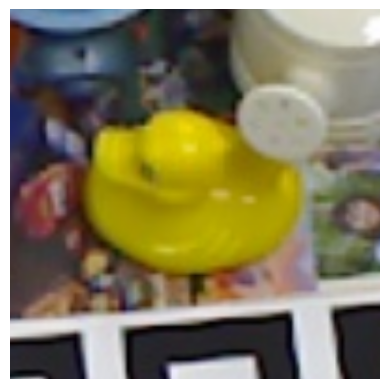

In [65]:
plt.imshow(vis_base_image)
plt.axis('off')
plt.show()

In [66]:
# Convert correspondences from tensors to numpy arrays.
best_corresp_np = tensors_to_arrays(
    corresp[final_pose["corresp_id"]]
)

In [67]:
# IDs and scores of the matched templates.
matched_template_ids = [c["template_id"] for c in corresp]
matched_template_scores = [c["template_score"] for c in corresp]

In [68]:
# Skip evaluation if there is no ground truth available, and only keep
# the estimated poses.
pose_eval_dict = None
pose_eval_dict_coarse = None
if instance["gt_anno"] is not None:

    retrieved_templates_camera_m2c = [
        repre.template_cameras_cam_from_model[tpl_id]
        for tpl_id in matched_template_ids
    ]

    timer.start()
    pose_eval_dict = pose_evaluator.update(
        scene_id=bop_chunk_id,
        im_id=bop_im_id,
        inst_id=inst_j,
        hypothesis_id=hypothesis_id,
        base_image=vis_base_image,
        object_repre_vertices=tensor_to_array(repre.vertices),
        obj_lid=object_lid,
        object_pose_m2w=pose_m2w,
        object_pose_m2w_gt=instance["gt_anno"].pose,
        orig_camera_c2w=orig_camera_c2w,
        camera_c2w=camera_c2w,
        pred_mask=instance["input_mask_modal"],
        gt_mask=instance["gt_anno"].masks_modal,
        corresp=best_corresp_np,
        retrieved_templates_camera_m2c=retrieved_templates_camera_m2c,
        time_per_inst=times,
        inlier_radius=opts.pnp_inlier_thresh,
        object_mesh_vertices=object_mesh["pts"],
        object_syms=object_syms,
        object_diameter=object_diameter,
    )
    timer.elapsed("Time for pose evaluation")


else:
    pose_eval_dict = pose_evaluator.update_without_anno(
        scene_id=bop_chunk_id,
        im_id=bop_im_id,
        inst_id=inst_j,
        hypothesis_id=hypothesis_id,
        object_repre_vertices=tensor_to_array(repre.vertices),
        obj_lid=object_lid,
        object_pose_m2w=pose_m2w,
        orig_camera_c2w=orig_camera_c2w,
        camera_c2w=orig_camera_c2w,
        time_per_inst=times,
        corresp=best_corresp_np,
        inlier_radius=(opts.pnp_inlier_thresh),
    )
    

object_pose_m2w_gt = None
if "gt_anno" in instance and instance["gt_anno"] is not None:
    object_pose_m2w_gt = instance["gt_anno"].pose

I0528 11:23:21.325 4329 eval_util.py:157] MSSD error: 12.553625524504092, id: 2613
I0528 11:23:21.326 4329 eval_util.py:165] MSPD error : 28.671207955960785, id: 7824
I0528 11:23:21.328 4329 misc.py:41] Time for pose evaluation: 0.01544s


In [69]:
# IDs and scores of the matched templates.
matched_template_ids = [c["template_id"] for c in corresp]
matched_template_scores = [c["template_score"] for c in corresp]

timer.start()
vis_tiles += vis_util.vis_inference_results(
    base_image=vis_base_image,
    object_repre=repre_np,
    object_lid=object_lid,
    object_pose_m2w=pose_m2w, # pose_m2w,
    object_pose_m2w_gt=object_pose_m2w_gt,
    feature_map_chw=feature_map_chw,
    feature_map_chw_proj=feature_map_chw_proj,
    vis_feat_map=opts.vis_feat_map,
    object_box=box_amodal.array_ltrb(),
    object_mask=mask_modal,
    camera_c2w=camera_c2w,
    corresp=best_corresp_np,
    matched_template_ids=matched_template_ids,
    matched_template_scores=matched_template_scores,
    best_template_ind=final_pose["corresp_id"],
    renderer=renderer,
    pose_eval_dict=pose_eval_dict,
    corresp_top_n=opts.vis_corresp_top_n,
    inlier_thresh=(opts.pnp_inlier_thresh),
    object_pose_m2w_coarse=pose_m2w_coarse,
    pose_eval_dict_coarse=pose_eval_dict_coarse,
    # For paper visualizations:
    vis_for_paper=opts.vis_for_paper,
    extractor=extractor,
)
timer.elapsed("Time for visualization")

I0528 11:23:22.738 4329 misc.py:41] Time for visualization: 1.40563s


1.4056336879730225

In [70]:
# Assemble visualization tiles to a grid and save it.
if len(vis_tiles):
    if repre.feat_vis_projectors[0].pca.n_components == 12:
        pca_tiles = np.vstack(vis_tiles[1:5])
        vis_tiles = np.vstack([vis_tiles[0]] + vis_tiles[5:])
        vis_grid = np.hstack([vis_tiles, pca_tiles])
    else:
        vis_grid = np.vstack(vis_tiles)
    ext = ".png" if opts.vis_for_paper else ".jpg"
    vis_path = os.path.join(
        output_dir,
        f"{bop_chunk_id}_{bop_im_id}_{object_lid}_{inst_j}_{hypothesis_id}{ext}",
    )
    inout.save_im(vis_path, vis_grid)
    logger.info(f"Visualization saved to {vis_path}")

    if opts.debug:
        pts_path = os.path.join(
            output_dir,
            f"{bop_chunk_id}_{bop_im_id}_{object_lid}_{inst_j}_{hypothesis_id}_vertice_error.ply",
        )
        vis_util.vis_pointcloud_error(
            repre_np,
            pose_m2w,
            object_pose_m2w_gt,
            camera_c2w,
            0,
            pts_path,
        )

I0528 11:23:22.859 4329 693456400.py:15] Visualization saved to /Workspace/inference/lmo_v1/9/2_3_9_0_0.png


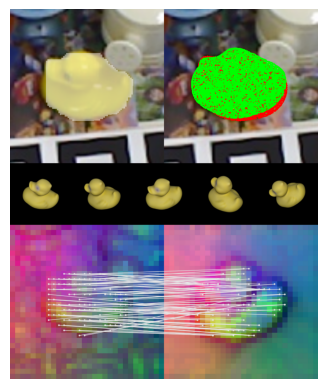

In [71]:
plt.imshow(vis_grid)
plt.axis('off')
plt.show()

In [72]:
# Empty unused GPU cache variables.
if device == "cuda":
    time_start = time.time()
    torch.cuda.empty_cache()
    gc.collect()
    time_end = time.time()
    logger.info(f"Garbage collection took {time_end - time_start} seconds.")

I0528 11:23:23.126 4329 901158972.py:7] Garbage collection took 0.1475517749786377 seconds.


In [73]:
# Save the pose estimates.
if opts.save_estimates:
    results_path = os.path.join(output_dir, "estimated-poses.json")
    logger.info("Saving estimated poses to: {}".format(results_path))
    pose_evaluator.save_results_json(results_path)

I0528 11:23:23.134 4329 2027554204.py:4] Saving estimated poses to: /Workspace/inference/lmo_v1/9/estimated-poses.json
